# Lunar orbit propagation with degree 20 spherical harmonics gravity model
In this example, the use of the gravity_sperical_harmonics functions will be demonstrated. Using Goddard Lunar Gravity Model 3, the orbit of a satellite in low Lunar orbit will be propagated. Due to time constraints, relatively low degree and order of the gravity model are used as well as relatively large tolerances in Scipy's RK45 integrator.

In [1]:
# Imports
import matplotlib.pyplot as plt
import pykep as pk
import scipy as sp
import numpy as np
%matplotlib inline

In [2]:
# Load the gravity model
r_m, mu_m, c, s, max_degree, max_order = pk.util.load_gravity_model("glgm3_150.txt")

In [3]:
# Define initial orbital parameters

# a, e, i, RAAN, AOP, E
kepl_init_state = np.array([1.882105e06, 0.05, np.radians(92), 0, 3*np.pi/2, 0])

# Convert to cartesian state
cart_init_state = np.concatenate(pk.par2ic(kepl_init_state, mu_m))

In [4]:
# Function to calculate the state derivative.
def propagate(t, state):
    # Rotational rate of the Moon
    w_m = 2.661695728e-6  # rad/s
    
    # Get the absolute rotation (assuming alpha(t0) = 0)
    alpha = w_m * t
    
    # Build the rotation matrix
    sin = np.sin(alpha)
    cos = np.cos(alpha)
    
    transformation = np.array([[cos, sin, 0], 
                               [-sin, cos, 0],
                               [0, 0, 1]])
    
    # Get the state in the inertial reference frame
    rotated_pos = np.dot(transformation, state[0:3])
    
    # gravity_spherical_harmonic needs an (N x 3) input array
    acc = pk.util.gravity_spherical_harmonic(np.array([rotated_pos]), r_m, mu_m, c, s, 10, 0)[0]
    
    delta_state = np.array([state[3],
                            state[4],
                            state[5],
                            acc[0],
                            acc[1],
                            acc[2]])
    
    return delta_state

In [5]:
# Run the integration of the orbit for one day
solution = sp.integrate.solve_ivp(propagate, (0, 3600*24), cart_init_state, rtol=1e-6, atol=1e-6)

time_hist = solution['t']
state_hist = np.transpose(solution['y'])

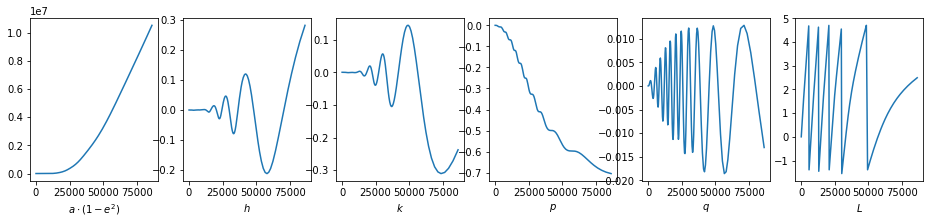

In [6]:
# Transform cartesian to modified equinoctial
eq_state_hist = np.zeros(state_hist.shape)
for i, state in enumerate(state_hist):
    eq_state_hist[i] = pk.ic2eq(state[0:3], state[3:6], mu_m)

labels = [r"$a \cdot \left( 1 - e^2 \right)$", r"$h$", r"$k$", r"$p$", r"$q$", r"$L$"]
# Plot the orbit
plt.figure(1, figsize=(16, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.plot(time_hist, eq_state_hist[:, i] - eq_state_hist[0, i])
    plt.xlabel(labels[i])